<a href="https://colab.research.google.com/github/yoshimoto-s/TensorflowObjectAPI_Colab/blob/master/ObjectDetectionTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tensorflow Object Detection APIのトレーニングをするためのColabファイルです**

---



### Step 1. 環境の準備

環境のチェック  
[GPU OK] が出てくれば大丈夫！

In [0]:
#@title Check Environment {display-mode: "form"}

#GPU環境の確認
import platform
print("python version: "+platform.python_version())

!pip install tensorflow  1>/dev/null
#現在のObjectDetectionの対応Tensorflowは1.8らしいんだけど、1.8じゃうまく動かない...
import tensorflow as tf;
print("tensorflow version: "+tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found')
    print('ランタイムの設定がGPUになっていることを確認してください')
print('GPU OK')



python version: 3.6.7
tensorflow version: 1.13.1
GPU OK


環境作成がうまく行ったか確認 最後に [OK]が出れば大丈夫

In [0]:
#@title ObjectDetectionAPI Installation {display-mode: "form"}

#install  env
print("Dependency env installing...")
!apt-get install protobuf-compiler python-pil python-lxml python-tk 1>/dev/null
!pip install Cython contextlib2 jupyter pillow lxml matplotlib 1>/dev/null
!pip install prompt_toolkit==1.0.15 1>/dev/null

%cd /content/
#特定のコミットを使用する必要があるかもしれない(要検討)
print("models cloning...")
!git clone https://github.com/tensorflow/models.git &> /dev/null

#Cocoapi
print("coco installing...")
!git clone https://github.com/cocodataset/cocoapi.git &> /dev/null
%cd cocoapi/PythonAPI
!make &>/dev/null
!cp -r pycocotools /content/models/research/

#compile protos
print("proto compiling...")
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

print("Set environ variables")
import os
os.environ['PYTHONPATH'] += ":"+os.getcwd()
os.environ['PYTHONPATH'] += ":"+os.getcwd()+"/slim"

### Other treatment
!sed -i -e 's/category_index.values()/list(category_index.values())/' /content/models/research/object_detection/model_lib.py

### Other requirment
!pip install beautifulsoup4 requests 1>/dev/null
!pip install qrcode 1>/dev/null

print("Check environment")
!python object_detection/builders/model_builder_test.py

Dependency env installing...
ipython 5.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.4, but you'll have prompt-toolkit 2.0.9 which is incompatible.
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.15 which is incompatible.
/content
models cloning...
coco installing...
/content/cocoapi/PythonAPI
proto compiling...
/content/models/research
Set environ variables
Check environment

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

............s...
----------------------------------------------------------------------
Ran 16 tests in 0.069s

OK (skipped=1)


### Step 2. データを準備する

必要なUtilityを定義します

In [0]:
#@title Utility Config {display-mode: "form"}

import glob
import os
from xml.etree.ElementTree import *
import time
from tqdm import tqdm

class Util:
    @staticmethod
    def GetAvailablePreTrains(path):
        graphInfoList = []
        for root, dirs, files in os.walk(path):
            for f in files:
                if f == 'pipeline.config':
                    graphInfo = {}
                    graphInfo['pipeline_path'] = os.path.join(root, f)
                    ckpt_list = glob.glob(os.path.join(root, 'model.ckpt*.index'))
                    if len(ckpt_list) > 0:
                        ckpt_list.sort(key=lambda x: os.path.getmtime(x))
                        ckpt_prefix = ckpt_list[-1][:-6]
                        graphInfo['checkpoint_path'] = os.path.abspath(ckpt_prefix)
                    else:
                        ckpt_list = glob.glob(os.path.join(root, '*/model.ckpt*.index'))
                        if len(ckpt_list) > 0:
                            ckpt_list.sort(key=lambda x: os.path.getmtime(x))
                            ckpt_prefix = ckpt_list[-1][:-6]
                            graphInfo['checkpoint_path'] = os.path.abspath(ckpt_prefix)

                    if('pipeline_path' in graphInfo and 'checkpoint_path' in graphInfo):
                        graphInfoList.append(graphInfo)
                        #print("==============")
                        #print("%d\tpipeline_path:  \t%s" % (len(graphInfoList) - 1, graphInfo['pipeline_path']))
                        #print("  \tcheckpoint_path:\t%s" % (graphInfo['checkpoint_path']))
        return graphInfoList

    @staticmethod
    def GetGraphList(path):
        graphInfoList = []
        for root, dirs, files in os.walk(path):
            for f in files:
                if f == 'frozen_inference_graph.pb':
                    graphInfo = {}
                    graphInfo['graph_path'] = os.path.join(root, f)
                    graphInfo['label_path'] = os.path.relpath(os.path.join(root, '../labelmap.pbtxt'))
                    graphInfoList.append(graphInfo)
                    print("==============")
                    print("%d\tgraph_path:\t%s" % (len(graphInfoList) - 1, graphInfo['graph_path']))
                    print("  \tlabel_path:\t%s" % (graphInfo['label_path']))
        return graphInfoList

    @staticmethod
    def GetLabels(path):
        labels = []
        xml_files = Util.GetXmlFiles(path)
        for f in tqdm(xml_files):
            try:
                tree = parse(f) 
                elem = tree.getroot()
                for n in elem.findall(".//name"):
                    if n.text not in labels:
                        labels.append(n.text)
            except:
                print("read error %s" % f)
        print("",flush=True)
        return labels

    @staticmethod
    def GetXmlFiles(path):
        xml_files = []
        for root, dirs, files in os.walk(path):
            for f in files:
                if f.lower().endswith('.xml'):
                    xml_files.append(os.path.relpath(os.path.join(root,f)))
        return xml_files

    @staticmethod
    def GetJPEGFiles(path):
        jpg_files = []
        for root, dirs, files in os.walk(path):
            for f in files:
                if f.lower().endswith('.jpg'):
                    jpg_files.append(os.path.relpath(os.path.join(root,f)))
        return jpg_files
print("Util Define Done")




Util Define Done


In [0]:
#@title Mount Google Drive {display-mode: "form"}

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#@title TFRecord Util {display-mode: "form"}

from object_detection.utils import dataset_util
from PIL import Image
from xml.etree.ElementTree import *
import time
from object_detection.protos import string_int_label_map_pb2
from tqdm import tqdm
import random
import json
import glob
from tqdm import tqdm
import requests
import contextlib2
import math
from object_detection.dataset_tools import tf_record_creation_util
from io import BytesIO 

max_num_per_tfrecord = 5000
max_examples = 50000

def create_tf_record_labelBox(json_url, order, train_ratio, output_path):
    res = requests.get(json_url)
    json_dict = json.loads(res.text)
    categories = []
    images = []
    
    categories = []
    images = []
    annotations = []
    for data in json_dict:
        if data['Label'] != 'Skip':
            objNum = 0
            for label in data['Label']:
                objNum += len(data['Label'][label])
                if label not in categories:
                    categories.append(label)
            if objNum > 0:
                images.append(data['Labeled Data'])
                annotations.append(data['Label'])
                    
    labels = categories
    split_num = int(len(images) * train_ratio)
    train_images = images[:split_num]
    train_annos = annotations[:split_num]
    test_images = images[split_num:]
    test_annos = annotations[split_num:]
    
    print("",flush=True)
    print("----Creating Train Data", flush=True)
    create_tf_record_from_json_dict(train_images, train_annos, labels, os.path.join(output_path,"train.record"))
    print("----Creating Test Data", flush=True)
    create_tf_record_from_json_dict(test_images, test_annos, labels, os.path.join(output_path,"test.record"))
    create_labelmap(labels, os.path.join(output_path, "labelmap.pbtxt"))
    print("TF Record Creation Complete.")
    return labels
    
def create_tf_record_from_json_dict(images, annotations, label_list, output_path):
    class_list = {}
    for i,l in enumerate(label_list):
        class_list[l] = {"id":i+1, "num":0}
    if len(images) > max_examples:
        images = images[0:max_examples]
    #writer = tf.python_io.TFRecordWriter(output_path)
    num_shards = math.ceil(len(images) / max_num_per_tfrecord)
    with contextlib2.ExitStack() as tf_record_close_stack:
        output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
        tf_record_close_stack, output_path, num_shards)
        for i, img in enumerate(tqdm(images)):
            output_shard_index = i % num_shards
            
            #id = img["id"]
            #url = img["file_name"]
            res = requests.get(img)
            encoded_image_data = res.content
            pimg = Image.open(BytesIO(encoded_image_data))
            width, height = pimg.size
            filename = b''
            image_format = b'jpeg'
            
            xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
            xmaxs = [] # List of normalized right x coordinates in bounding box  (1 per box)
            ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
            ymaxs = [] # List of normalized bottom y coordinates in bounding box (1 per box)
            classes_text = [] # List of string class name of bounding box (1 per box)
            classes = [] # List of integer class id of bounding box (1 per box)
            annos = annotations[i]
            for cat in annos:
                for geo in annos[cat]:
                    xmin = width -1
                    ymin = height -1
                    xmax = 0
                    ymax = 0
                    for p in geo['geometry']:
                        p['x'] = min(width-1, max(0, p['x']))
                        p['y'] = min(height-1, max(0, p['y']))
                        xmin = min(p['x'], xmin)
                        ymin = min(p['y'], ymin)
                        xmax = max(p['x'], xmax)
                        ymax = max(p['y'], ymax)
                        
                    if (xmax - xmin) * (ymax - ymin) > 0:
                        xmins.append(float(xmin) / width)
                        ymins.append(float(ymin) / height)
                        xmaxs.append(float(xmax) / width)
                        ymaxs.append(float(ymax) / height)
                        name = cat
                        classes_text.append(name.encode())
                        classes.append(class_list[name]["id"])
                        class_list[name]["num"] += 1
                    
            tf_example = create_tf_example(filename, width, height, 
                                 encoded_image_data, image_format,
                                 xmins, xmaxs, ymins, ymaxs, classes_text, classes)
            output_tfrecords[output_shard_index].write(tf_example.SerializeToString())
        
        print("",flush=True)
        print("TFRecord convert done...%d" % len(images)) 
        print("-----Label counts-----")
        for k,v in class_list.items():
            print(k + ": " + str(v["num"]))
    
def create_tf_record_labelImage(input_dir, order, train_ratio, output_path): 
    xml_files = Util.GetXmlFiles(input_dir)
    labels = Util.GetLabels(input_dir)
    if order == "random":
        random.shuffle(xml_files)
    elif order == "date":
        xml_files.sort(key=lambda f: int(filter(str.isdigit, os.path.basename(f))))
    split_num = int(len(xml_files) * train_ratio)
    train_xml_files = xml_files[:split_num]
    test_xml_files = xml_files[split_num:]

    print("",flush=True)
    print("----Creating Train Data", flush=True)
    create_tf_record_from_xml_list(train_xml_files, labels, os.path.join(output_path,"train.record"))
    print("----Creating Test Data", flush=True)
    create_tf_record_from_xml_list(test_xml_files, labels, os.path.join(output_path, "test.record"))
    create_labelmap(labels, os.path.join(output_path, "labelmap.pbtxt"))
    print("TF Record Creation Complete.", flush=True)
    return labels

def create_tf_record_from_xml_list(xml_list, label_list, output_path):
    class_list = {}
    for i,l in enumerate(label_list):
        class_list[l] = {"id":i+1, "num":0}
        
    if len(xml_list) > max_examples:
        xml_list = xml_list[0:max_examples]
    ignoreCount = 0
    num_shards = math.ceil(len(xml_list) / max_num_per_tfrecord)
    with contextlib2.ExitStack() as tf_record_close_stack:
        output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
        tf_record_close_stack, output_path, num_shards)
        for i, f in enumerate(tqdm(xml_list)):
            tf_example =create_tf_example_labelImage(f, class_list)
            if tf_example != None:
                output_shard_index = i % num_shards
                output_tfrecords[output_shard_index].write(tf_example.SerializeToString())
            else:
                ignoreCount += 1
    
    #writer.close()
    print("",flush=True)
    print("TFRecord convert done...%d" % len(xml_list)) 
    if ignoreCount > 0:
        print("%d files ignored" % ignoreCount)
    print("-----Label counts-----")
    for k,v in class_list.items():
        print(k + ": " + str(v["num"]))
        

def create_tf_example_labelImage(xml_path,  class_list):
    img_path = os.path.abspath(os.path.dirname(xml_path) + "/../JPEGImages") + "/" + os.path.basename(xml_path).replace('.xml','.jpg')
    if(not os.path.exists(img_path)):
        return None
    
    img = Image.open(img_path)
    height = img.size[1] # Image height
    width = img.size[0] # Image width
    #filename = img_path # Filename of the image. Empty if image is not from file
    filename = b'' # Filename of the image. Empty if image is not from file
    encoded_image_data = None # Encoded image bytes
    image_format = b'jpeg' # b'jpeg' or b'png'
    
    with tf.gfile.GFile(img_path,'rb') as fid:
        encoded_image_data = fid.read()

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box  (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    
    try:
        tree = parse(xml_path)
        elem = tree.getroot()
    except ParseError:
        return None

    for obj in elem.getiterator("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = bndbox.find("xmin").text
        xmax = bndbox.find("xmax").text
        ymin = bndbox.find("ymin").text
        ymax = bndbox.find("ymax").text
        classes_text.append(name.encode())
        classes.append(class_list[name]["id"])
        xmins.append(float(xmin) / width)
        ymins.append(float(ymin) / height)
        xmaxs.append(float(xmax) / width)
        ymaxs.append(float(ymax) / height)
        class_list[name]["num"] += 1

    return create_tf_example(filename, width, height, 
                             encoded_image_data, image_format,
                             xmins, xmaxs, ymins, ymaxs, classes_text, classes)

def create_tf_example(filename, width, height, 
                      encoded_image_data, image_format, 
                      xmins, xmaxs, ymins, ymaxs, classes_text, classes):
    
     return tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))

from google.protobuf import text_format
def create_labelmap(labels, output_path):
    label_config = string_int_label_map_pb2.StringIntLabelMap()
    for i,l in enumerate(labels):
        item = label_config.item.add()
        item.name = l
        item.id = i+1
        item.display_name = l
    
    labels_text = text_format.MessageToString(label_config)
    with tf.gfile.Open(output_path, "wb") as f:
        f.write(labels_text)
        
        
print("TFRecord Util Define Done")

TFRecord Util Define Done


使用するデータを指定する  
dataset_typeには以下のいづれかの値を選んでください。  
LabelBox: https://app.labelbox.com こちらで作ったもの  
LabelImage: https://github.com/tzutalin/labelImg こちらで作ったもの  

LabelBoxを選んだ場合はdataset_urlにcoco形式のJsonのURLを,   
LabelImageを選んだ場合はセル実行後にzip or tar.gz形式のファイルをアップロードしてください

In [0]:
#@title Set Dataset Dir {display-mode:"form"}

from google.colab import files
import shutil
import os

dataset_type = 'LabelBox' #@param ['LabelBox', 'LabelImage']

dataset_url = 'https://storage.googleapis.com/labelbox-exports/cjudjh7vgc21b08714iykzgrd/cjudjhr0xbqvb0755f5ozh1j0/export-2019-04-12T11:23:55.020Z.json' #@param {type: "string"}
dataset_dir = '' #@param {type: "string"}
dataset_path = "\"" + dataset_dir + "\""


dataset_train_ratio = 85 #@param {type:"slider", min: 0, max:100}
dataset_order = 'random' #@param ['random', 'date']

if dataset_type == 'LabelImage':
    !mkdir -p /content/dataset
    print("copying files...")
    !rsync -az --info=progress2 $dataset_path /content/dataset
    !echo "copy files done!"
    %cd /content/dataset
    files = glob.glob("/content/dataset/*.zip", recursive=True)
    for f in files:
        print("unpacking...")
        shutil.unpack_archive(f)
    labels = Util.GetLabels("/content/dataset")
    print("Labels: ")
    print(labels)

if there are any labeling misstakes use command '!find /content/dataset  -type f -name \"*.xml\" | xargs sed -i -e 's/before/after/g''

学習に必要なデータベースを作成する

In [0]:
#@title Create TF Record {display-mode: "form"}

!mkdir -p "/content/tfrecords"

labels = []
if dataset_type == "LabelBox":
    labels = create_tf_record_labelBox(dataset_url, dataset_order, float(dataset_train_ratio)/100, "/content/tfrecords")
    
elif dataset_type == "LabelImage":
   labels = create_tf_record_labelImage("/content/dataset", dataset_order, float(dataset_train_ratio)/100, "/content/tfrecords")
    


----Creating Train Data


100%|██████████| 939/939 [01:00<00:00, 13.72it/s]


TFRecord convert done...939
-----Label counts-----
House: 1373
Train: 1407
Cloud: 1666
River: 1662
Heliport: 798
Human: 1765
----Creating Test Data



100%|██████████| 166/166 [00:10<00:00, 16.53it/s]


TFRecord convert done...166
-----Label counts-----
House: 245
Train: 243
Cloud: 281
River: 316
Heliport: 128
Human: 233
TF Record Creation Complete.


### Step 3. モデルを準備する

このColaboratoryから使用できる学習済みモデルの一覧を表示します  
Base Modelは下記に用意されているものhttps://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md  

model_dirを設定すると、そこに学習済みモデルがある場合Local Modelsに表示されます
左のファイルツリーからパスをコピーしてください

In [0]:
#@title List Available Models {display-mode: "form"}

!mkdir -p /content/pretrained_model/ &> /dev/null
%cd /content/pretrained_model 

import requests
from bs4 import BeautifulSoup
import os
import shutil


#@markdown 既存のデータを使う場合は下記にGoogleDriveのパスを記入
model_dir = '/content/drive/My Drive/PretrainedModels/Tensorflow' #@param {type: "string"}
model_path = model_dir

local_model_list = {}
if os.path.exists(model_path):
    gList = Util.GetAvailablePreTrains(model_path)
    for i,g in enumerate(gList):
        mName = os.path.basename(os.path.dirname(g['pipeline_path']))
        local_model_list[mName] = os.path.dirname(g['pipeline_path'])

r = requests.get("https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md")
soup = BeautifulSoup(r.text, 'lxml')

base_model_list = {}
for i,a in enumerate(soup.select('a[href^="http://download.tensorflow.org/models/object_detection/"]')):
    base_model_list[a.get_text()] = a.get('href')


model_name = ""
model_location = ""
model_type = ""
# Display List 
import IPython
from google.colab import output

def set_model_list():
    with output.redirect_to_element("#local-items"):
        for v,k in local_model_list.items():
            li_elem = "<li><ahref=\"javascript:void(0)\" onclick=\"setModel('{0}', '{1}')\">{0}</a></li>".format(v, "local")
            display(IPython.display.HTML(li_elem))
            
    with output.redirect_to_element("#base-items"):
        for v,k in base_model_list.items():
            li_elem = "<li><ahref=\"javascript:void(0)\" onclick=\"setModel('{0}', '{1}')\">{0}</a></li>".format(v, "base")
            display(IPython.display.HTML(li_elem))
                                         
def set_model(name,mtype):
    global model_name, model_type, model_location
    model_name = name
    model_type = mtype
    if mtype == "local":
        model_location = local_model_list[name]
    else:
        model_location = base_model_list[name]
    
def get_model():
    if model_type == "local":
        shutil.copytree(model_location, "/content/pretrained_model/%s" % model_name)
    else:
        !wget $model_location &> /dev/null
        !tar xzvf *.tar.gz &> /dev/null
    print("Model preparation done.")
    
output.register_callback('notebook.ShowModelList', set_model_list)
output.register_callback('notebook.SetModel', set_model)
output.register_callback('notebook.GetModel', get_model)
display(IPython.display.HTML('''
    <h3>Local Models:</h3>
    <ol id="local-items"></ol>
    <h3>Base Models:</h3>
    <ol id="base-items"></ol>
    <div>
        Selected Model:<span id="model_name"></span>
    </div>
    <button class="square_btn" id="get-model-button" onclick="getModel()" disabled>Get Selected Model</button>
    <style type="text/css">
    <!--
    li {
        color:blue; 
        line-height:1.5;
        cursor : pointer;
        text-decoration: underline;
    }
    .square_btn{
        display: inline-block;
        padding: 0.5em 1em;
        text-decoration: none;
        background: #668ad8;/*ボタン色*/
        color: #FFF;
        border-bottom: solid 4px #627295;
        border-radius: 3px;
    }
    .square_btn:active {/*ボタンを押したとき*/
        -ms-transform: translateY(4px);
        -webkit-transform: translateY(4px);
        transform: translateY(4px);/*下に動く*/
        border-bottom: none;/*線を消す*/
    }
    -->
    </style>
    <script>
        google.colab.kernel.invokeFunction('notebook.ShowModelList', [], {});
        
        function setModel(name,type) {
            google.colab.kernel.invokeFunction('notebook.SetModel', [name, type], {});
            document.getElementById("model_name").innerHTML = name + "("+type+")" 
            document.getElementById("get-model-button").disabled = false
        }
        function getModel() {
            google.colab.kernel.invokeFunction('notebook.GetModel', [], {});
        }
    </script>
    '''))

/content/pretrained_model


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model preparation done.


### Step 4. 学習の設定をする

In [0]:
#@title Prepare Run Config {display-mode:"form"}

train_steps = 50000  #@param {type: "number"}
eval_show_num = 30 #@param {type: "number"}
eval_interval = 600 #@param {type: "number"}
max_eval_num = 0 #@param {type: "number"}

##########################################
!mkdir -p /content/work
#!mkdir -p /content/work/eval

from object_detection.protos import pipeline_pb2
from object_detection.utils import config_util
import glob

models = Util.GetAvailablePreTrains("/content/pretrained_model")

config_path = "/content/models/research/object_detection/samples/configs/"+model_name +".config"

if model_type == "base" and os.path.exists(config_path):
    print("use samples/configs/**")
else:
    print("use model included config")
    config_path = models[0]['pipeline_path']

config = config_util.get_configs_from_pipeline_file(config_path)

if(config['model'].HasField('ssd')):
    config['model'].ssd.num_classes = len(labels)
elif(config['model'].HasField('faster_rcnn')):
    config['model'].faster_rcnn.num_classes = len(labels)

config["train_config"].fine_tune_checkpoint = models[0]['checkpoint_path']
config["train_config"].num_steps = train_steps
config["train_input_config"].label_map_path = "/content/tfrecords/labelmap.pbtxt"
config["train_input_config"].tf_record_input_reader.input_path.pop()
train_files = glob.glob("/content/tfrecords/*train.record*")
for f in train_files:
    config["train_input_config"].tf_record_input_reader.input_path.append(f)
    
config["eval_input_config"].label_map_path = "/content/tfrecords/labelmap.pbtxt"
config["eval_input_config"].tf_record_input_reader.input_path.pop()
train_files = glob.glob("/content/tfrecords/*test.record*")
for f in train_files:
    config["eval_input_config"].tf_record_input_reader.input_path.append(f)
    
config['eval_config'].num_visualizations = eval_show_num
config['eval_config'].max_evals = 0
#config['eval_config'].visualization_export_dir = "/content/work/eval"
#config['eval_config'].include_metrics_per_category = True
config['eval_config'].eval_interval_secs = eval_interval
#config['eval_config'].metrics_set.append('coco_detection_metrics')

pipeline = config_util.create_pipeline_proto_from_configs(config)
config_util.save_pipeline_config(pipeline, "/content/work")

#!cat /content/work/pipeline.config

use model included config
INFO:tensorflow:Writing pipeline config file to /content/work/pipeline.config


pipelineファイルの中身をみたければ...  
!cat /content/work/pipeline.config  

もしpipeline.configを手動でいじりたかったら、左のファイルリストから/work/pipeline.configをダウンロードして、上書きしてね



### Step 5. 学習の実行

学習を監視するためのTensorboardを起動します

tensorboard run...
/content/ngrok
ngrok run...
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
Watch runing status bellow
https://d7723e69.ngrok.io


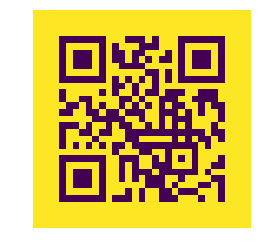

In [0]:
#@title Run Tensorboard {display-mode: "form"}
import subprocess
from subprocess import Popen
from time import sleep 

#@markdown もしngrokのアカウントを持ってればtimeoutを回避できる(空白でも5時間は見れる)
ngrok_token = '4hj8zDQwV1VS2YqeyjCCv_4cgo3nbXKa5VNs8NAbrg' #@param {type: "string"}

res = subprocess.call('ps aux | grep tensorflow | grep -v grep', shell=True)
if int(res) > 0:
    print("tensorboard run...")
    cmd = "tensorboard --logdir /content/work/ --host 0.0.0.0 --port 6006"
    proc = Popen( cmd,shell=True )
else:
    print("tensorboard already runing...")

sleep(5)

!mkdir -p /content/ngrok
%cd /content/ngrok
res = subprocess.call('ps aux | grep ngrok | grep -v grep', shell=True)
if int(res) > 0:
    !rm -rf *
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip &>/dev/null
    !unzip *.zip &>/dev/null
    print("ngrok run...")
    !./ngrok authtoken $ngrok_token
    cmd = "./ngrok http 6006"
    proc = Popen( cmd , shell=True)
else:
    print("ngrok already runing...")

sleep(5)

import requests
import json
import qrcode
from PIL import Image
import matplotlib.pyplot as plt
import numpy as npj
import os.path

res = requests.get('http://localhost:4040/api/tunnels')
import re
#print(res.text)
m = re.search(r"(https:\/\/.*?ngrok.io)", res.text)
if m:
    print("Watch runing status bellow")
    url = m.group(1)
    print(url)
    img = qrcode.make(url)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

結果を出力するための場所を定義します  
Google Driveを指定することで、Googleドライブに結果を出力できます

In [0]:
#@title Output Dir on Google Drive {display-mode:"form"}

log_dir = '/content/drive/My Drive/PretrainedModels/Tensorflow/BigTsumiki/big_tsumiki_20190412' #@param {type: "string"}
log_path = log_dir

import os
if not os.path.exists(log_path):
    print("There is not such dir: %s" % log_path)

学習を実行

In [0]:
#@title Run Train {display-mode: "form"}
from subprocess import Popen
import subprocess

res = subprocess.call('ps aux | grep rsync | grep -v grep', shell=True)
if int(res) > 0:
    cmd = "/bin/bash -c 'while sleep 30; do rsync -a /content/work/* \"%s\"; done'" % log_path
    proc = Popen( cmd,shell=True )
    print("rsync set /content/work/* to %s" % log_path)

%cd /content/models/research
!python object_detection/model_main.py  \
            --pipeline_config_path=/content/work/pipeline.config \
            --model_dir=/content/work/log \
            --sample_1_of_n_eval_examples=1 

rsync set /content/work/* to /content/drive/My Drive/PretrainedModels/Tensorflow/BigTsumiki/big_tsumiki_20190412
/content/models/research

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softm

### Step 6. 学習データをエクスポートする

In [0]:
#@title Export Graph {display-mode: "form"}

#現在(2018/11/28)のObjectDetectionのサポートバージョンは1.9.0
!pip install tensorflow==1.9.0 &> /dev/null

import glob
import os

from subprocess import Popen
import subprocess

res = subprocess.call('ps aux | grep rsync | grep -v grep', shell=True)
if int(res) > 0:
    cmd = "/bin/bash -c 'while sleep 30; do rsync -a /content/work/* \"%s\"; done'" % log_path
    proc = Popen( cmd,shell=True )
    print("rsync set /content/work/* to %s" % log_path)

%cd /content/models/research
search_dir = "/content/work/log/"
files = glob.glob("/content/work/log/model.ckpt-*.index")
files.sort(key=lambda x: os.path.getmtime(x))
prefix = os.path.splitext(files[-1])[0]

print("export checkpoint : %s" % prefix )

!rm -rf /content/work/export
!cp -f /content/tfrecords/labelmap.pbtxt /content/work/
!python object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/work/pipeline.config \
    --trained_checkpoint_prefix=$prefix\
    --output_directory=/content/work/export

### Appendix SandBox

In [0]:
#@title Change Tensorflow version {display-mode: "form"}
import subprocess
import re
import IPython
from google.colab import output

res = subprocess.check_output("git ls-remote --tags https://github.com/tensorflow/tensorflow.git | awk '{print $2}'", shell=True)
tags = res.decode('utf-8').split("\n")

versions = []
for t in tags:
    #print(t)
    m = re.search(r"v(1\.[0-9]+\.[0-9]+)$", t)
    if m:
        versions.append(m.group(1))
        
versions.sort(key=lambda s: list(map(int, s.split('.'))))
versions.reverse()

def set_version_list():
    with output.redirect_to_element("#version-list"):
        for i,v in enumerate(versions):
            if i == 0:
                radio_elem = "<input type=\"radio\" name=\"version\" value=\"{0}\" checked />{0}".format(v)
            else:
                radio_elem = "<input type=\"radio\" name=\"version\" value=\"{0}\" />{0}".format(v)
            display(IPython.display.HTML(radio_elem))

def change_version(version):
    print("Changing tensorflow version to %s" % version)
    !pip install tensorflow==$version &> /dev/null
    print("Change version completed")

output.register_callback('notebook.SetVersionList', set_version_list)
output.register_callback('notebook.ChangeVersion', change_version)
display(IPython.display.HTML('''
    <h3>Change Tensorflow version:</h3>
    <div id="version-list">
    </div>
    <button class="square_btn" id="change_btn" onclick="changeVersion()">Change Version</button>
    <div id="debug"></div>
    <style type="text/css">
    <!--
    .square_btn{
        display: inline-block;
        padding: 0.5em 1em;
        text-decoration: none;
        background: #668ad8;/*ボタン色*/
        color: #FFF;
        border-bottom: solid 4px #627295;
        border-radius: 3px;
    }
    .square_btn:active {/*ボタンを押したとき*/
        -ms-transform: translateY(4px);
        -webkit-transform: translateY(4px);
        transform: translateY(4px);/*下に動く*/
        border-bottom: none;/*線を消す*/
    }
    -->
    </style>
    <script>
        google.colab.kernel.invokeFunction('notebook.SetVersionList', [], {});
        
        function changeVersion() {
            var elems = document.getElementsByName( "version" ) ;
            for (var i=0; i<elems.length; i++) {
	           if ( elems[i].checked ) {
                  google.colab.kernel.invokeFunction('notebook.ChangeVersion', [elems[i].value], {});
		          break ;
	           }
            }
        }
    </script>
    '''))

In [0]:
#学習プロセスが動いているか確認
!ps auxf | grep model_main | grep -v grep

In [0]:
!ps aux | grep tensorboard | grep -v grep

In [0]:
!ps aux | grep ngrok | grep -v grep

In [0]:
#学習ログを削除
!rm -rf /content/work/log

In [0]:
!rm -rf /content/dataset

In [0]:
!du -sh /content/tfrecords/*


In [0]:
23000 % 5000

In [0]:
!rm -rf /content/dataset

In [0]:
!mkdir -p /content/work